<a href="https://colab.research.google.com/github/Jaja-Chang/CAB320-Artificial-Intelligence-Project/blob/main/Flowers_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect the file with your google drive 
from google.colab import drive 
drive.mount('/content/drive')

# you can add your root directory path if it's needed 
root_dir = '/content/drive/My Drive/CAB320/Assignment 2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# impost modules 
import os
import cv2                          # for image loading and colour conversion
import glob
import math
import numpy as np                  # for reshaping, array manipulation
import pandas as pd
import tensorflow as tf             # for bulk image resize
import matplotlib.pyplot as plt     # for plotting

from PIL import Image
from tensorflow import keras 
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

### Helper Functions

In [ ]:
# Print iterations progress
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=100, fill='█', printEnd="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

In [ ]:
def resize_images(image, target_size, pad=False):
    """
    Resize an image or a batch of images
    :param image: The image or batch of images to resize
    :param target_size: The height and width of the target size
    :param pad: Whether the padding is applied to prevent distortion
    :return: The resized image as a numpy array
    """
    return tf.image.resize_with_pad(image, target_size[0], target_size[1]).numpy() if pad else tf.image.resize(image,
                                                                                                               target_size).numpy()

In [ ]:
def load_directory(path, label, resize=None, pad=False):
    print("Loading from %s" % path)
    files = glob.glob(os.path.join(path, '*.jpg'))
    total_count = len(files)
    print("%d files found" % len(files))
    x = []
    y = []

    # loop through the images, loading them and extracting the subject ID
    for i, f in enumerate(files):
        img = np.array(Image.open(f).convert("RGB")) / 255.0
        # print(os.path.basename(f), img.shape)
        x.append(img if resize is None else resize_images(img, resize, pad))
        y.append(label)
        # del img  # Remove from memory
        print_progress_bar(i + 1, total_count, prefix='Loading Images:', suffix='', length=50)
    return np.array(x), np.array(y)

In [ ]:
def show_images(images, labels, figsize=[20,20],cmap='gray', num_to_plot=100):
    """
    Shows the first n images in the loaded and transformed data
    :param count: The number of images to show
    :param figsize: The size of the figure
    :return: Nothing
    """
    rows = math.floor(math.sqrt(num_to_plot))
    cols = math.ceil(num_to_plot / rows)
    fig = plt.figure(figsize=figsize)
    for i in range(num_to_plot):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[i, :], cmap=cmap)
        ax.set_title(labels[i])
        ax.axis('off')

In [ ]:
def split_data(data, label, train_ratio=0.6, val_ratio=0.2, shuffle_data=True, random_state=42):
  test_size = 1 - train_ratio
  if val_ratio == None:
    train_X, test_X, train_Y, test_Y = train_test_split(data, label, test_size=test_size, random_state=random_state, shuffle=shuffle_data)
    return train_X, train_Y, test_X, test_Y
  else:
    train_X, test_X, train_Y, test_Y = train_test_split(data, label, test_size=test_size, random_state=random_state, shuffle=shuffle_data)
    test_size = val_ratio / test_size
    val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size=test_size, random_state=random_state, shuffle=shuffle_data)
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [ ]:
def eval_model(model, history, test_X, test_Y):

    fig = plt.figure(figsize=[16, 6])    

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['loss'], label='Train Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Train Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    ax.set_title('Loss & Accuracy vs. Time')
    
    pred = model.predict(test_X)
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(test_Y, indexes)
    pred_acc = accuracy_score(test_Y, indexes, normalize=True)
    pred_f1 = f1_score(test_Y, indexes, average='macro')

    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(np.unique(test_Y))))
    c.plot(ax = ax)
    ax.set_title('Test set prediction\nAccuary: %f\nMean f1-score: %f' % (pred_acc, pred_f1))
    # ax.set_title('Accuracy: %1.3f \n F1 score: %1.3f' % (pred_acc, pred_f1));
    
    print(classification_report(test_Y, indexes))

In [ ]:
def mobileNetV2_pretrained(num_class, input_shape=(224, 224, 3)):
  base_model = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), 
                           include_top=False, pooling='avg')
  base_model.trainable = False
  inputs = keras.Input(shape=input_shape)
  x = base_model(inputs, training=False)
  # x = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(5, activation='softmax', name='output_layer')(x)
  model = keras.Model(inputs, outputs)
  return model

## Load Data & Pre-processing 

In [ ]:
daisy = 0
dandelion = 1
roses = 2
sunflowers = 3
tulips = 4

daisy_X, daisy_Y = load_directory(os.path.join(root_dir, 'small_flower_dataset/daisy'), daisy, resize=(224, 224), pad=True)
dandelion_X, dandelion_Y = load_directory(os.path.join(root_dir, 'small_flower_dataset/dandelion'), dandelion, resize=(224, 224), pad=True)
roses_X, roses_Y = load_directory(os.path.join(root_dir, 'small_flower_dataset/roses'), roses, resize=(224, 224), pad=True)
sunflowers_X, sunflowers_Y = load_directory(os.path.join(root_dir, 'small_flower_dataset/sunflowers'), sunflowers, resize=(224, 224), pad=True)
tulips_X, tulips_Y = load_directory(os.path.join(root_dir, 'small_flower_dataset/tulips'), tulips, resize=(224, 224), pad=True)

Loading from /content/drive/My Drive/CAB320/Assignment 2/small_flower_dataset/daisy
200 files found
Loading Images: |██████████████████████████████████████████████████| 100.0% 
Loading from /content/drive/My Drive/CAB320/Assignment 2/small_flower_dataset/dandelion
200 files found
Loading Images: |██████████████████████████████████████████████████| 100.0% 
Loading from /content/drive/My Drive/CAB320/Assignment 2/small_flower_dataset/roses
200 files found
Loading Images: |██████████████████████████████████████████████████| 100.0% 
Loading from /content/drive/My Drive/CAB320/Assignment 2/small_flower_dataset/sunflowers
200 files found
Loading Images: |██████████████████████████████████████████████████| 100.0% 
Loading from /content/drive/My Drive/CAB320/Assignment 2/small_flower_dataset/tulips
200 files found
Loading Images: |██████████████████████████████████████████████████| 100.0% 


In [ ]:
X = np.concatenate([daisy_X, dandelion_X, roses_X, sunflowers_X, tulips_X], axis=0)
Y = np.concatenate([daisy_Y, dandelion_Y, roses_Y, sunflowers_Y, tulips_Y], axis=0)
X, Y = shuffle(X, Y)

# sanity check 
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (1000, 224, 224, 3)
Y shape:  (1000,)


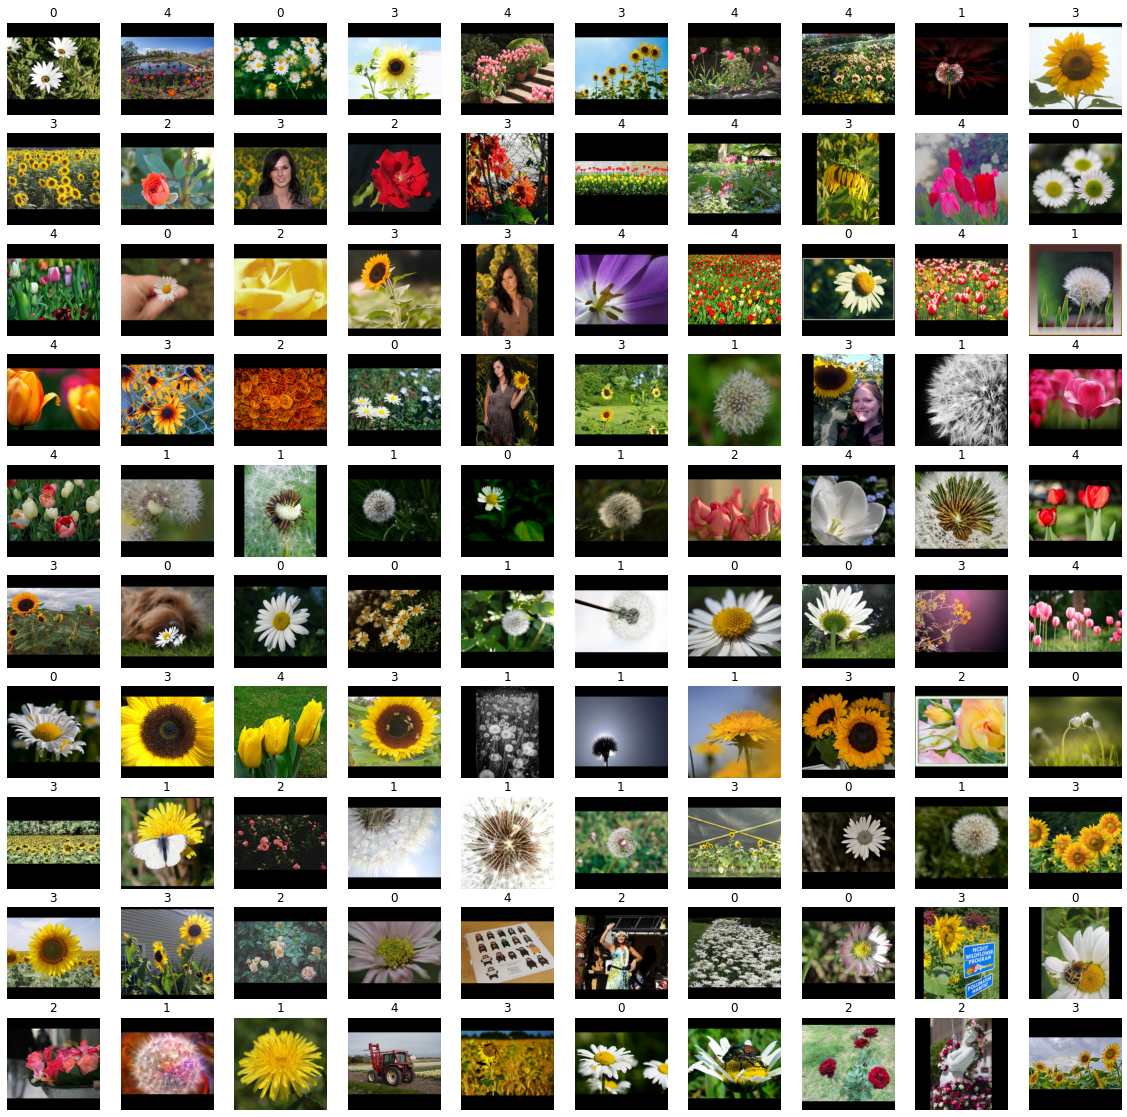

In [ ]:
# visualise some images 
show_images(X, Y, figsize=[20,20],cmap='gray')

In [ ]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = split_data(X, Y, 
                                                            train_ratio=0.6, 
                                                            val_ratio=0.2, 
                                                            shuffle_data=True, 
                                                            random_state=42)
print('train_X shape: ', train_X.shape)
print('train_Y shape', train_Y.shape)
print('val_X shape: ', val_X.shape)
print('val_Y shape', val_Y.shape)
print('test_X shape: ', test_X.shape)
print('test_Y shape', test_Y.shape)

train_X shape:  (600, 224, 224, 3)
train_Y shape (600,)
val_X shape:  (200, 224, 224, 3)
val_Y shape (200,)
test_X shape:  (200, 224, 224, 3)
test_Y shape (200,)


## Build Model 

<keras.engine.input_layer.InputLayer object at 0x7fc93fd81c10> False
<keras.layers.convolutional.Conv2D object at 0x7fc9405ecd50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc9a526ff90> False
<keras.layers.advanced_activations.ReLU object at 0x7fcac0158cd0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fca35c33d50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fca13219690> False
<keras.layers.advanced_activations.ReLU object at 0x7fc93fbefad0> False
<keras.layers.convolutional.Conv2D object at 0x7fc93fbcc510> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fca3437d210> False
<keras.layers.convolutional.Conv2D object at 0x7fc93fbbb250> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc9a4082510> False
<keras.layers.advanced_activations.ReLU object at 0x7fc93fbbbf50> False
<keras.layers.convolutional.ZeroPadding2D 

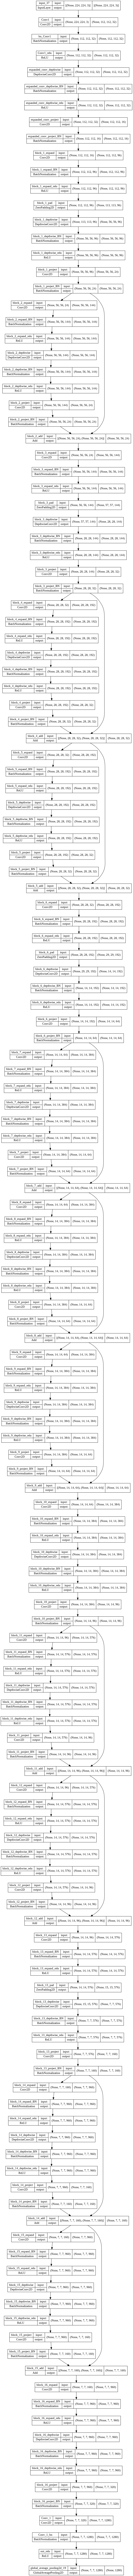

In [ ]:
base_model = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg')

# Freeze the base model
base_model.trainable = False

# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

# model structure 
keras.utils.plot_model(base_model, show_shapes=True)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


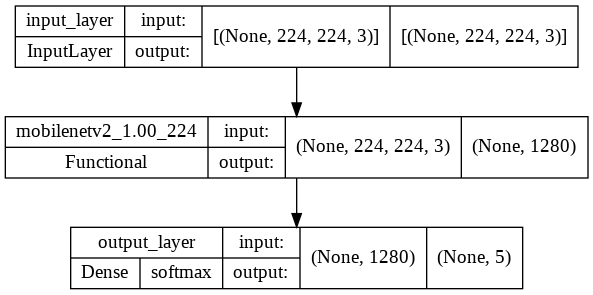

In [ ]:
inputs = keras.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)

# A Dense classifier with 5 units as we have 5 classes 
outputs = keras.layers.Dense(5, activation='softmax', name='output_layer')(x)
model = keras.Model(inputs, outputs)
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

## Compile and Train the Model

In [ ]:
batch_size = 20
epochs = 40
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0, nesterov=False),
              metrics=['accuracy'])
history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 66ms/step - loss: 0.0831 - accuracy: 0.9983 - val_loss: 0.4692 - val_accuracy: 0.8450
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0815 - accuracy: 0.9983 - val_loss: 0.4619 - val_accuracy: 0.8550
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0797 - accuracy: 0.9983 - val_loss: 0.4677 - val_accuracy: 0.8550
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0781 - accuracy: 0.9983 - val_loss: 0.4721 - val_accuracy: 0.8450
Epoch 5/40
30/30 [==============================] - 1s 29ms/step - loss: 0.0762 - accuracy: 0.9983 - val_loss: 0.4693 - val_accuracy: 0.8600
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0744 - accuracy: 0.9983 - val_loss: 0.4724 - val_accuracy: 0.8550
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0726 - accuracy: 1.0000 - val_loss: 0.4735 - val_accuracy: 0.8450
Epoch 8/40
30/30 [======

## Plot and Evaluate

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        45
           1       0.84      0.89      0.86        35
           2       0.77      0.84      0.81        32
           3       0.85      0.85      0.85        46
           4       0.89      0.79      0.84        42

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



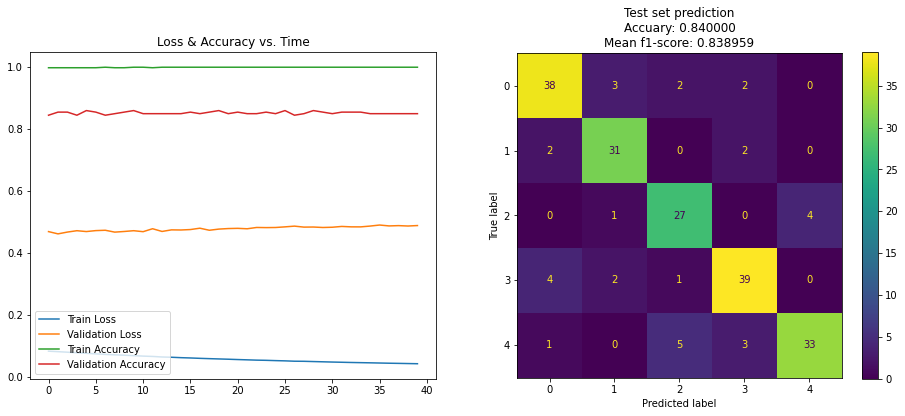

In [ ]:
eval_model(model, history.history, test_X, test_Y)

## Experiment (learning rate)

Experiment with 3 different orders of magnitude for the learning rate. 

In [ ]:
num_class = 5
input_shape = (224, 224, 3)

### Learning rate = 0.1

In [ ]:
model_1 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

In [ ]:
lr = 0.1
model_1.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=0, nesterov=False),
              metrics=['accuracy'])
history_1 = model_1.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 62ms/step - loss: 2.9339 - accuracy: 0.5350 - val_loss: 1.4691 - val_accuracy: 0.6600
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 0.6427 - accuracy: 0.8167 - val_loss: 0.5530 - val_accuracy: 0.8650
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 0.2558 - accuracy: 0.9200 - val_loss: 0.6762 - val_accuracy: 0.8600
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.1771 - accuracy: 0.9333 - val_loss: 0.5909 - val_accuracy: 0.8500
Epoch 5/40
30/30 [==============================] - 1s 29ms/step - loss: 0.0852 - accuracy: 0.9783 - val_loss: 0.5712 - val_accuracy: 0.8700
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0516 - accuracy: 0.9917 - val_loss: 0.5640 - val_accuracy: 0.8850
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0359 - accuracy: 0.9983 - val_loss: 0.5538 - val_accuracy: 0.8800
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        45
           1       0.86      0.91      0.89        35
           2       0.80      0.88      0.84        32
           3       0.82      0.89      0.85        46
           4       0.92      0.79      0.85        42

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.85      0.85       200



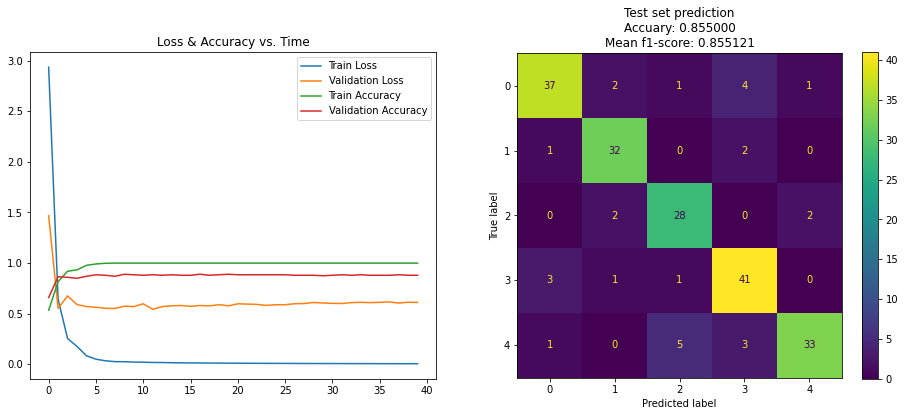

In [ ]:
eval_model(model_1, history_1.history, test_X, test_Y)

### Learning rate = 0.01

In [ ]:
model_2 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

lr = 0.01
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=0, nesterov=False),
              metrics=['accuracy'])
history_2 = model_2.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 62ms/step - loss: 1.2314 - accuracy: 0.5033 - val_loss: 0.9442 - val_accuracy: 0.6650
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 0.7556 - accuracy: 0.7367 - val_loss: 0.8014 - val_accuracy: 0.7050
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 0.5968 - accuracy: 0.7967 - val_loss: 0.7142 - val_accuracy: 0.7750
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.5103 - accuracy: 0.8417 - val_loss: 0.6423 - val_accuracy: 0.7950
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 0.4512 - accuracy: 0.8667 - val_loss: 0.6008 - val_accuracy: 0.8250
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3956 - accuracy: 0.8800 - val_loss: 0.5918 - val_accuracy: 0.7850
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3600 - accuracy: 0.8883 - val_loss: 0.5671 - val_accuracy: 0.8500
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        45
           1       0.82      0.89      0.85        35
           2       0.76      0.81      0.79        32
           3       0.82      0.89      0.85        46
           4       0.86      0.76      0.81        42

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



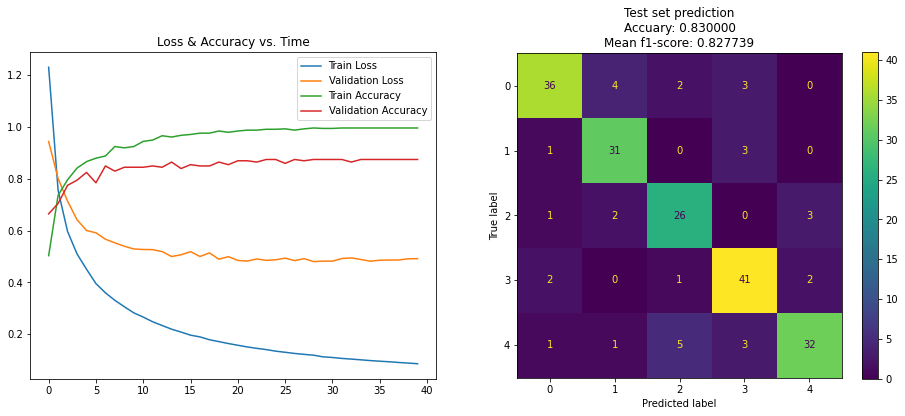

In [ ]:
eval_model(model_2, history_2.history, test_X, test_Y)

### Learning rate = 0.001

In [ ]:
model_3 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

lr = 0.001
model_3.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=0, nesterov=False),
              metrics=['accuracy'])
history_3 = model_3.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 64ms/step - loss: 1.8236 - accuracy: 0.1867 - val_loss: 1.7378 - val_accuracy: 0.2400
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 1.5703 - accuracy: 0.3283 - val_loss: 1.5802 - val_accuracy: 0.3100
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 1.4142 - accuracy: 0.4133 - val_loss: 1.4497 - val_accuracy: 0.3800
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 1.2867 - accuracy: 0.4850 - val_loss: 1.3512 - val_accuracy: 0.4350
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 1.1851 - accuracy: 0.5333 - val_loss: 1.2614 - val_accuracy: 0.5000
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 1.1049 - accuracy: 0.5850 - val_loss: 1.1931 - val_accuracy: 0.5250
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 1.0341 - accuracy: 0.6133 - val_loss: 1.1421 - val_accuracy: 0.5450
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        45
           1       0.74      0.80      0.77        35
           2       0.76      0.78      0.77        32
           3       0.76      0.76      0.76        46
           4       0.83      0.71      0.77        42

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200



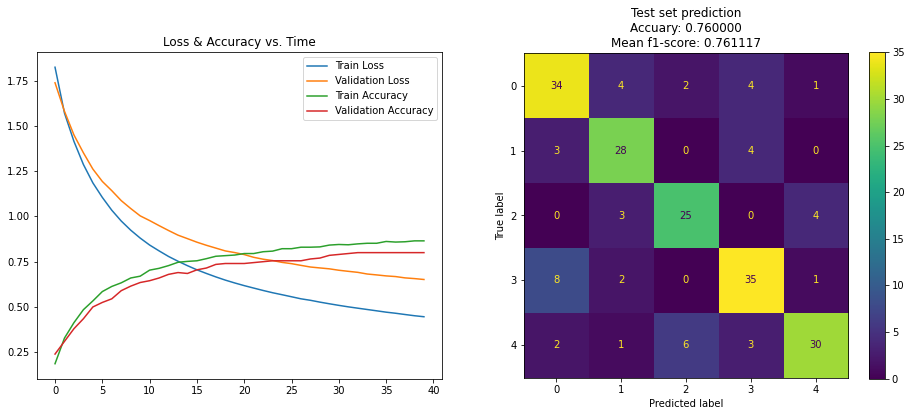

In [ ]:
eval_model(model_3, history_3.history, test_X, test_Y)

### Learning rate = 0.0001

In [ ]:
model_4 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

lr = 0.00001
model_4.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=0, nesterov=False),
              metrics=['accuracy'])
history_4 = model_4.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 62ms/step - loss: 1.8238 - accuracy: 0.2217 - val_loss: 1.9234 - val_accuracy: 0.2100
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 1.8188 - accuracy: 0.2217 - val_loss: 1.9182 - val_accuracy: 0.2100
Epoch 3/40
30/30 [==============================] - 1s 29ms/step - loss: 1.8139 - accuracy: 0.2233 - val_loss: 1.9131 - val_accuracy: 0.2100
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 1.8091 - accuracy: 0.2267 - val_loss: 1.9080 - val_accuracy: 0.2150
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 1.8043 - accuracy: 0.2250 - val_loss: 1.9031 - val_accuracy: 0.2150
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 1.7997 - accuracy: 0.2283 - val_loss: 1.8982 - val_accuracy: 0.2150
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 1.7951 - accuracy: 0.2300 - val_loss: 1.8934 - val_accuracy: 0.2150
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.50      0.16      0.24        45
           1       0.00      0.00      0.00        35
           2       0.19      0.34      0.25        32
           3       0.30      0.52      0.38        46
           4       0.19      0.17      0.18        42

    accuracy                           0.24       200
   macro avg       0.24      0.24      0.21       200
weighted avg       0.25      0.24      0.22       200



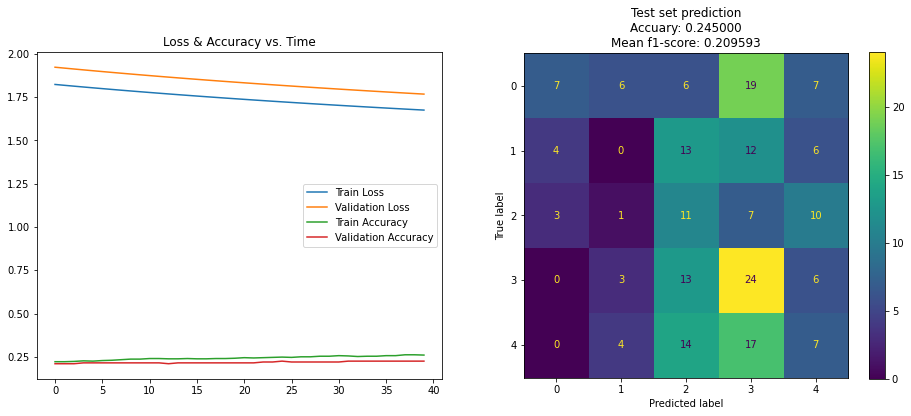

In [ ]:
eval_model(model_4, history_4.history, test_X, test_Y)

The experiment indicates that model_2 with lr = 1e-2 has the best performance. So, we are goin to use the model to perform the next experiment.

## Experiment (momentum)
With the best learning rate that you found in the previous task, add a non zero momentum to
the training with the SGD optimizer (consider 3 values for the momentum).

### Momentum = 0.2

In [ ]:
model_2 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

lr = 0.01
momentum = 0.2
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=momentum, nesterov=False),
              metrics=['accuracy'])
history_2 = model_2.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 64ms/step - loss: 1.1554 - accuracy: 0.5533 - val_loss: 0.8726 - val_accuracy: 0.6850
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 0.6831 - accuracy: 0.7633 - val_loss: 0.7275 - val_accuracy: 0.7250
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 0.5375 - accuracy: 0.8283 - val_loss: 0.6381 - val_accuracy: 0.7900
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.4492 - accuracy: 0.8567 - val_loss: 0.5953 - val_accuracy: 0.7950
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3948 - accuracy: 0.8783 - val_loss: 0.5850 - val_accuracy: 0.8200
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3506 - accuracy: 0.8950 - val_loss: 0.5519 - val_accuracy: 0.8350
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3196 - accuracy: 0.9217 - val_loss: 0.5586 - val_accuracy: 0.8200
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        45
           1       0.80      0.91      0.85        35
           2       0.76      0.78      0.77        32
           3       0.83      0.85      0.84        46
           4       0.84      0.76      0.80        42

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



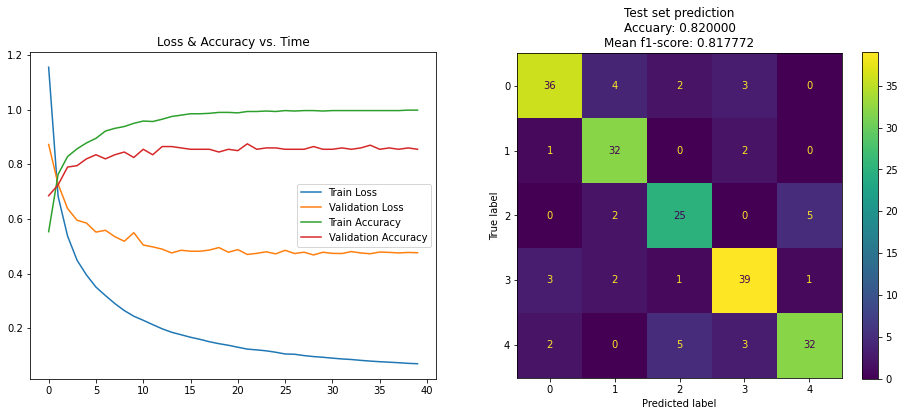

In [ ]:
eval_model(model_2, history_2.history, test_X, test_Y)

### Momentum = 0.3

In [ ]:
model_2 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

lr = 0.01
momentum = 0.3
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=momentum, nesterov=False),
              metrics=['accuracy'])
history_2 = model_2.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 62ms/step - loss: 1.1390 - accuracy: 0.5633 - val_loss: 0.8223 - val_accuracy: 0.6950
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 0.6500 - accuracy: 0.7850 - val_loss: 0.6425 - val_accuracy: 0.7800
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 0.5064 - accuracy: 0.8383 - val_loss: 0.6034 - val_accuracy: 0.8050
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.4195 - accuracy: 0.8817 - val_loss: 0.5735 - val_accuracy: 0.8000
Epoch 5/40
30/30 [==============================] - 1s 29ms/step - loss: 0.3688 - accuracy: 0.9000 - val_loss: 0.5284 - val_accuracy: 0.8350
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3226 - accuracy: 0.9117 - val_loss: 0.4939 - val_accuracy: 0.8500
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 0.2895 - accuracy: 0.9317 - val_loss: 0.4895 - val_accuracy: 0.8500
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.90      0.80      0.85        45
           1       0.84      0.91      0.88        35
           2       0.75      0.84      0.79        32
           3       0.83      0.85      0.84        46
           4       0.87      0.81      0.84        42

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



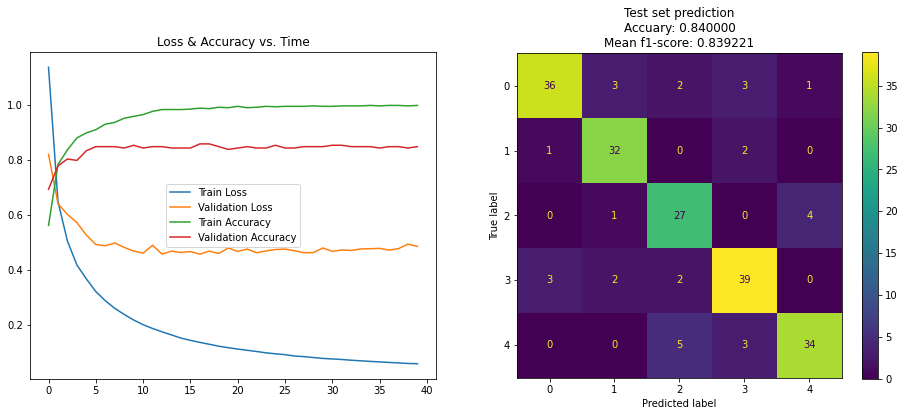

In [ ]:
eval_model(model_2, history_2.history, test_X, test_Y)

### Momentum = 0.6

In [ ]:
model_2 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

lr = 0.01
momentum = 0.6
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=momentum, nesterov=False),
              metrics=['accuracy'])
history_2 = model_2.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 63ms/step - loss: 1.0253 - accuracy: 0.6083 - val_loss: 0.6920 - val_accuracy: 0.8000
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 0.5125 - accuracy: 0.8433 - val_loss: 0.5837 - val_accuracy: 0.8300
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3872 - accuracy: 0.8717 - val_loss: 0.6194 - val_accuracy: 0.7850
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3172 - accuracy: 0.9083 - val_loss: 0.5719 - val_accuracy: 0.8300
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 0.2629 - accuracy: 0.9333 - val_loss: 0.5519 - val_accuracy: 0.8350
Epoch 6/40
30/30 [==============================] - 1s 28ms/step - loss: 0.2296 - accuracy: 0.9583 - val_loss: 0.5176 - val_accuracy: 0.8500
Epoch 7/40
30/30 [==============================] - 1s 28ms/step - loss: 0.1979 - accuracy: 0.9700 - val_loss: 0.5191 - val_accuracy: 0.8500
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        45
           1       0.84      0.89      0.86        35
           2       0.82      0.84      0.83        32
           3       0.85      0.89      0.87        46
           4       0.85      0.79      0.81        42

    accuracy                           0.84       200
   macro avg       0.84      0.85      0.84       200
weighted avg       0.85      0.84      0.84       200



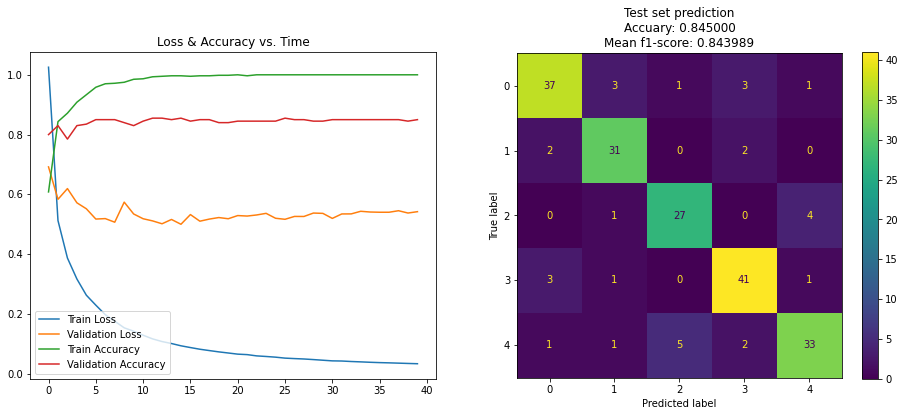

In [ ]:
eval_model(model_2, history_2.history, test_X, test_Y)

### Momentum = 0.9

In [ ]:
model_2 = mobileNetV2_pretrained(num_class=num_class, input_shape=input_shape)

lr = 0.01
momentum = 0.9
model_2.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.SGD(lr=lr, momentum=momentum, nesterov=False),
              metrics=['accuracy'])
history_2 = model_2.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 5s 62ms/step - loss: 0.9544 - accuracy: 0.6183 - val_loss: 0.7441 - val_accuracy: 0.7600
Epoch 2/40
30/30 [==============================] - 1s 28ms/step - loss: 0.3396 - accuracy: 0.8817 - val_loss: 0.6074 - val_accuracy: 0.8350
Epoch 3/40
30/30 [==============================] - 1s 28ms/step - loss: 0.1758 - accuracy: 0.9317 - val_loss: 0.5340 - val_accuracy: 0.8450
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0956 - accuracy: 0.9800 - val_loss: 0.5624 - val_accuracy: 0.8450
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0735 - accuracy: 0.9900 - val_loss: 0.5114 - val_accuracy: 0.8800
Epoch 6/40
30/30 [==============================] - 1s 29ms/step - loss: 0.0514 - accuracy: 1.0000 - val_loss: 0.5190 - val_accuracy: 0.8700
Epoch 7/40
30/30 [==============================] - 1s 29ms/step - loss: 0.0411 - accuracy: 1.0000 - val_loss: 0.5159 - val_accuracy: 0.8800
Epoch 8/40
30/30 [======

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        45
           1       0.84      0.91      0.88        35
           2       0.76      0.81      0.79        32
           3       0.83      0.85      0.84        46
           4       0.87      0.81      0.84        42

    accuracy                           0.84       200
   macro avg       0.84      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200



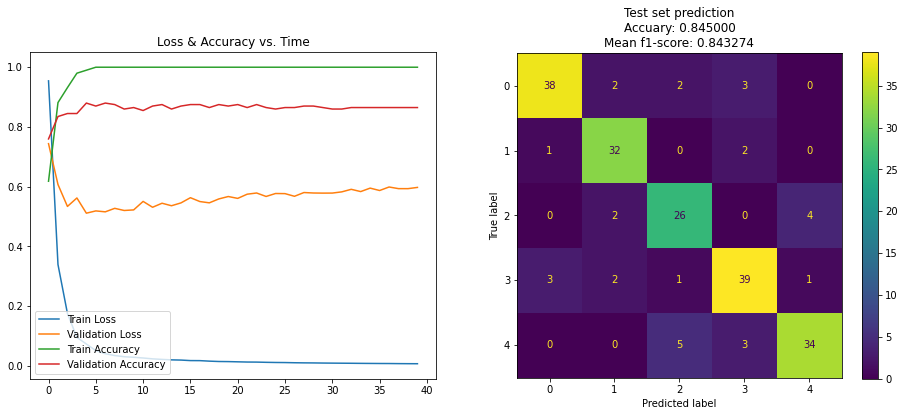

In [ ]:
eval_model(model_2, history_2.history, test_X, test_Y)

## Recommendation
According to the experiments, the parameters recommended are lr = 1e-2 and momentum = 0.3